This notebook aims to check the distribution of tracked ABI+GLM products.

In [1]:
from pyresample import create_area_def
import regionmask
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import proplot as plot
import shapely.vectorized
import cartopy.crs as ccrs
import dask.dataframe as dd
import shapely.geometry as sgeom
import matplotlib.patches as mpatches
from shapely.ops import unary_union
from shapely.prepared import prep
from goes2go.tools import field_of_view
import cartopy.io.shapereader as shpreader
from pyresample.bucket import BucketResampler

## Define areas

In [2]:
def get_geom(name, category='physical', resolution='50m'):
    # https://stackoverflow.com/questions/47894513/
    #    checking-if-a-geocoordinate-point-is-land-or-ocean-with-cartopy
    shp_fname = shpreader.natural_earth(name=name,
                                        resolution=resolution,
                                        category=category
                                       )
    if name == 'coastline':
        # https://shapely.readthedocs.io/en/stable/manual.html#object.buffer
        geom = unary_union(list(shpreader.Reader(shp_fname).geometries())).buffer(0.5)
    else:
        geom = unary_union(list(shpreader.Reader(shp_fname).geometries()))

    return geom, prep(geom)

In [3]:
land_polygon, land_geom = get_geom('land')
coast_polygon, coast_geom = get_geom('coastline')
ocean_polygon, ocean_geom = get_geom('ocean')

In [4]:
def get_fov():
    ds_abi = xr.open_dataset(glob('../data/GOES-16/ABI_L1/OR_ABI-L1b-RadC-M6C13_G16_s2020153000*')[0])
    ds_glm = xr.open_dataset(glob('../data/GOES-16/GLM_L2/OR_GLM-L2-LCFA_G16_s2020153000*')[0])

    FOV_abi, geo_abi = field_of_view(ds_abi)
    FOV_glm, geo_glm = field_of_view(ds_glm)

    x_abi = ds_abi.geospatial_lat_lon_extent.geospatial_lon_nadir+80
    y_abi = ds_abi.geospatial_lat_lon_extent.geospatial_lat_nadir

    return FOV_abi, FOV_glm, geo_abi, geo_glm, x_abi, y_abi

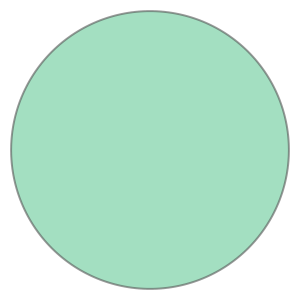

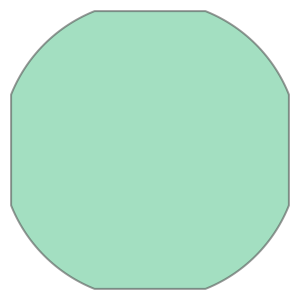

In [5]:
FOV_abi, FOV_glm,  geo_abi, geo_glm, x_abi, y_abi = get_fov()
display(FOV_abi, FOV_glm)

In [6]:
# fig, axs = plot.subplots(proj='pcarree', figsize=(6, 4))

# axs.add_geometries([FOV_abi], crs=geo_abi,
#                    facecolor='none', edgecolor='green7')

# axs.add_geometries([FOV_glm], crs=geo_glm,
#                    facecolor='none', edgecolor='orange7', linestyle='--')


# axs.text(ds.geospatial_lat_lon_extent.geospatial_lon_nadir+80,
#          ds.geospatial_lat_lon_extent.geospatial_lat_nadir,
#          'GOES-16 ABI', 
#          rotation=-90, va='center', fontsize=15, color='green7', fontweight='bold')

# axs.text(ds.geospatial_lat_lon_extent.geospatial_lon_nadir-40,
#          ds.geospatial_lat_lon_extent.geospatial_lat_nadir-65,
#          'GOES-16 GLM', va='center', fontsize=15, color='orange7', fontweight='bold')

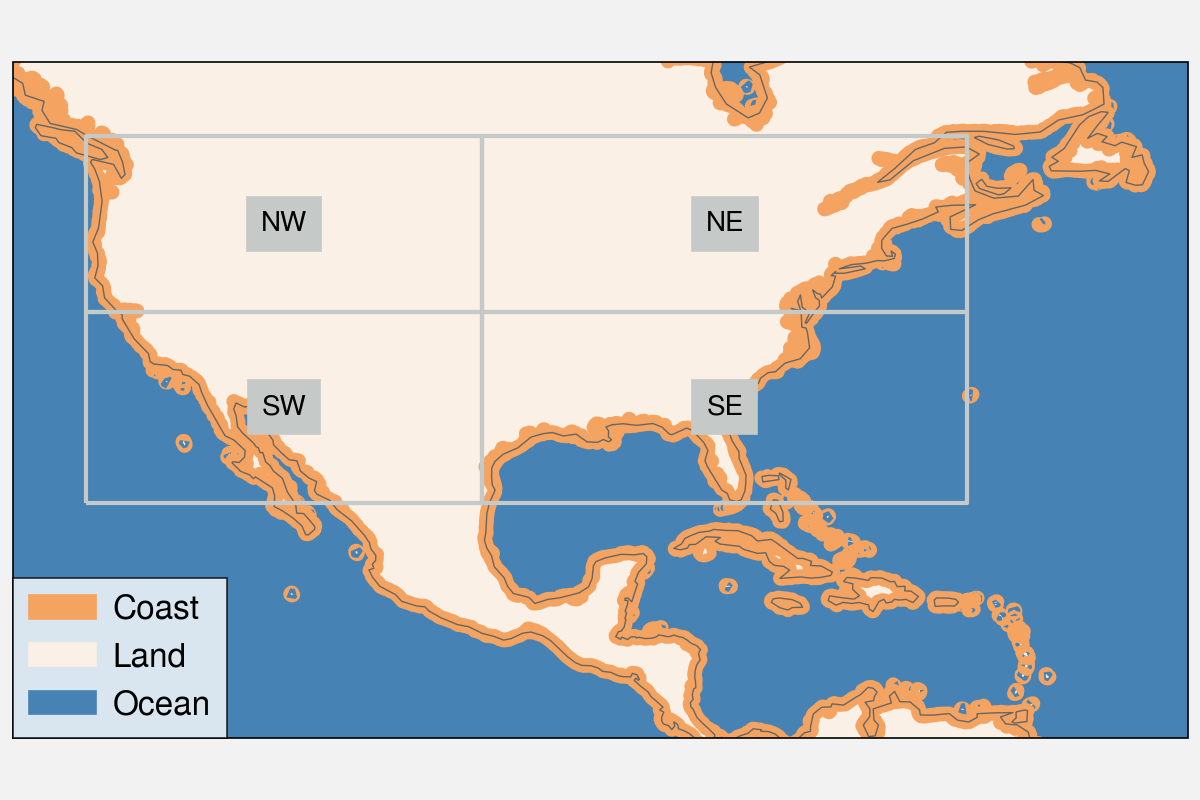

In [7]:
fig, axs = plot.subplots(proj='pcarree', figsize=(6, 4))

land_c = 'linen'
ocean_c = 'steelblue'#'darkcyan'
coast_c = 'sandybrown'

line_land = axs.add_geometries(land_polygon,
                                ccrs.PlateCarree(),
                                facecolor=land_c,
                                # edgecolor='yellow',
                                # linewidth=1
                               )

line_ocean = axs.add_geometries(ocean_polygon,
                                ccrs.PlateCarree(),
                                facecolor=ocean_c,
                                # edgecolor='yellow',
                                # linewidth=0.5,
                               )

line_coast = axs.add_geometries(coast_polygon,
                                ccrs.PlateCarree(),
                                facecolor=coast_c,
                                # edgecolor='yellow',
                                # linewidth=0.5,
                               )

# plot selected regions
US_nw = np.array([[-125, 38], [-98, 38], [-98, 50], [-125, 50]])
US_ne = np.array([[-98, 38], [-65, 38], [-65, 50], [-98, 50]])
US_sw = np.array([[-125, 25], [-98, 25], [-98, 38], [-125, 38]])
US_se = np.array([[-98, 25], [-65, 25], [-65, 38], [-98, 38]])

abbrevs = ['NW', 'NE', 'SW', 'SE']
USregions = regionmask.Regions([US_nw, US_ne, US_sw, US_se],
                               abbrevs=abbrevs,
                               name="US")

text_kws = dict(color='k', fontsize=10, bbox=dict(pad=5, color="silver"))
USregions.plot(label="abbrev", ax=axs, line_kws=dict(color='silver'), text_kws=text_kws)

# plot FOV
# axs.add_geometries([FOV_abi], crs=geo_abi,
#                    facecolor='none', edgecolor='green7')

# axs.add_geometries([FOV_glm], crs=geo_glm,
#                    facecolor='none', edgecolor='orange7', linestyle='--')

# axs.text(x_abi+80,
#          y_abi,
#          'GOES-16 ABI', 
#          rotation=-90, va='center', fontsize=15, color='green7', fontweight='bold')

# axs.text(x_abi-40,
#          y_abi-65,
#          'GOES-16 GLM', va='center', fontsize=15, color='orange7', fontweight='bold')

LegendElement = [
                 mpatches.Patch(color=coast_c, label='Coast'),
                 mpatches.Patch(color=land_c, label='Land'),
                 mpatches.Patch(color=ocean_c, label='Ocean'),
                ]
axs.legend(handles = LegendElement, loc='ll', ncols=1, prop={'size': 12})

# axs.format(lonlim=(-130, -55), latlim=(20, 55), grid=False)
axs.format(lonlim=(-130, -50), latlim=(9, 55), grid=False)

fig.savefig('../figures/region_mask.png')

## Case Number

In [30]:
merge_dir = '../data/GOES-16/merged/'
df = dd.read_csv(merge_dir+'merged_2020*.csv', skiprows=4).compute().dropna()
df = df[df['w']>0]
# df['flash_extent_density'] /= 5

In [31]:
values = []

for key, value in df[df['w']>0].groupby('area').groups.items():
    print(key, len(value))
    values.append(len(value))
print(np.sum(values), '\n')

# -- tropics --
tropics_values = []
print('Tropics')
for key, value in df[df['lat']<23.5].groupby('area').groups.items():
    print(key, len(value))
    tropics_values.append(len(value))
print(np.sum(tropics_values), '\n')

# -- midlatitudes --
midlatitudes_values = []
print('Midlatitude')
for key, value in df[df['lat']>23.5].groupby('area').groups.items():
    print(key, len(value))
    midlatitudes_values.append(len(value))
print(np.sum(midlatitudes_values), '\n')

coast 199516
land 370174
ocean 228786
798476 

Tropics
coast 134719
land 123409
ocean 96773
354901 

Midlatitude
coast 64797
land 246765
ocean 132013
443575 



In [32]:
for key, value in df[df['area']=='land'].groupby('region').groups.items():
    print(key, len(value))

NE 48378
NW 27273
Other 142276
SE 77091
SW 75156


In [33]:
'Tropical:', len(df[df['lat']<23.5]), 'Midlatitude:', len(df[df['lat']>23.5])

('Tropical:', 354901, 'Midlatitude:', 443575)

## Case Distribution

In [12]:
def set_resample(resolution):
    '''set the resampled region'''
    lon_min = -125
    lon_max = -50
    lat_min = 9
    lat_max = 55
    resample_res = resolution # resolution of resample grid (units: degree)

    # create the grid as same as cropped H8 data
    area = create_area_def('track_area',
                           {'proj': 'longlat', 'datum': 'WGS84'},
                           area_extent=[lon_min-resample_res/2,
                                        lat_min-resample_res/2,
                                        lon_max+resample_res/2,
                                        lat_max+resample_res/2],
                           resolution=resample_res,
                           units='degrees',
                           description=f'{resample_res}x{resample_res} degree lat-lon grid')

    # get lon and lat of defined area
    lon_coord, lat_coord = area.get_lonlats()
    
    return lon_coord, lat_coord, area

In [13]:
def plot_casenum(ax, lon, lat, data, title, label, vmin=0, vmax=None, ticks=None):
    '''plot the case number'''
    if vmax and ticks:
        values = plot.arange(vmin, vmax, ticks)
        levels = len(values)
    else:
        values = None
        levels = None

    m = ax.pcolormesh(lon, lat,
                      data,
                      cmap='Spectral_r',
                      vmin=vmin,
                      vmax=vmax,
                      levels=levels,
                      extend='max',
                      )

    ax.colorbar(m, loc='r',
                values=values,
                ticks=ticks,
                label=label,
                labelsize=12)

    ax.format(title=title)

In [14]:
lon_coord, lat_coord, area = set_resample(1)

resampler = BucketResampler(area,
                            df.lon.to_xarray().chunk(chunks={'index':100}).data,
                            df.lat.to_xarray().chunk(chunks={'index':100}).data)

counts = xr.DataArray(resampler.get_count().compute())
ht_mean = resampler.get_average(df['HT']).compute()
fed_mean = resampler.get_average(df['flash_extent_density']).compute()
mfa_mean = resampler.get_average(df['minimum_flash_area']).compute()

/public/home/zhangxin/new/miniconda3/envs/pyresample_min/lib/python3.8/site-packages/pyproj/crs/crs.py:1216: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


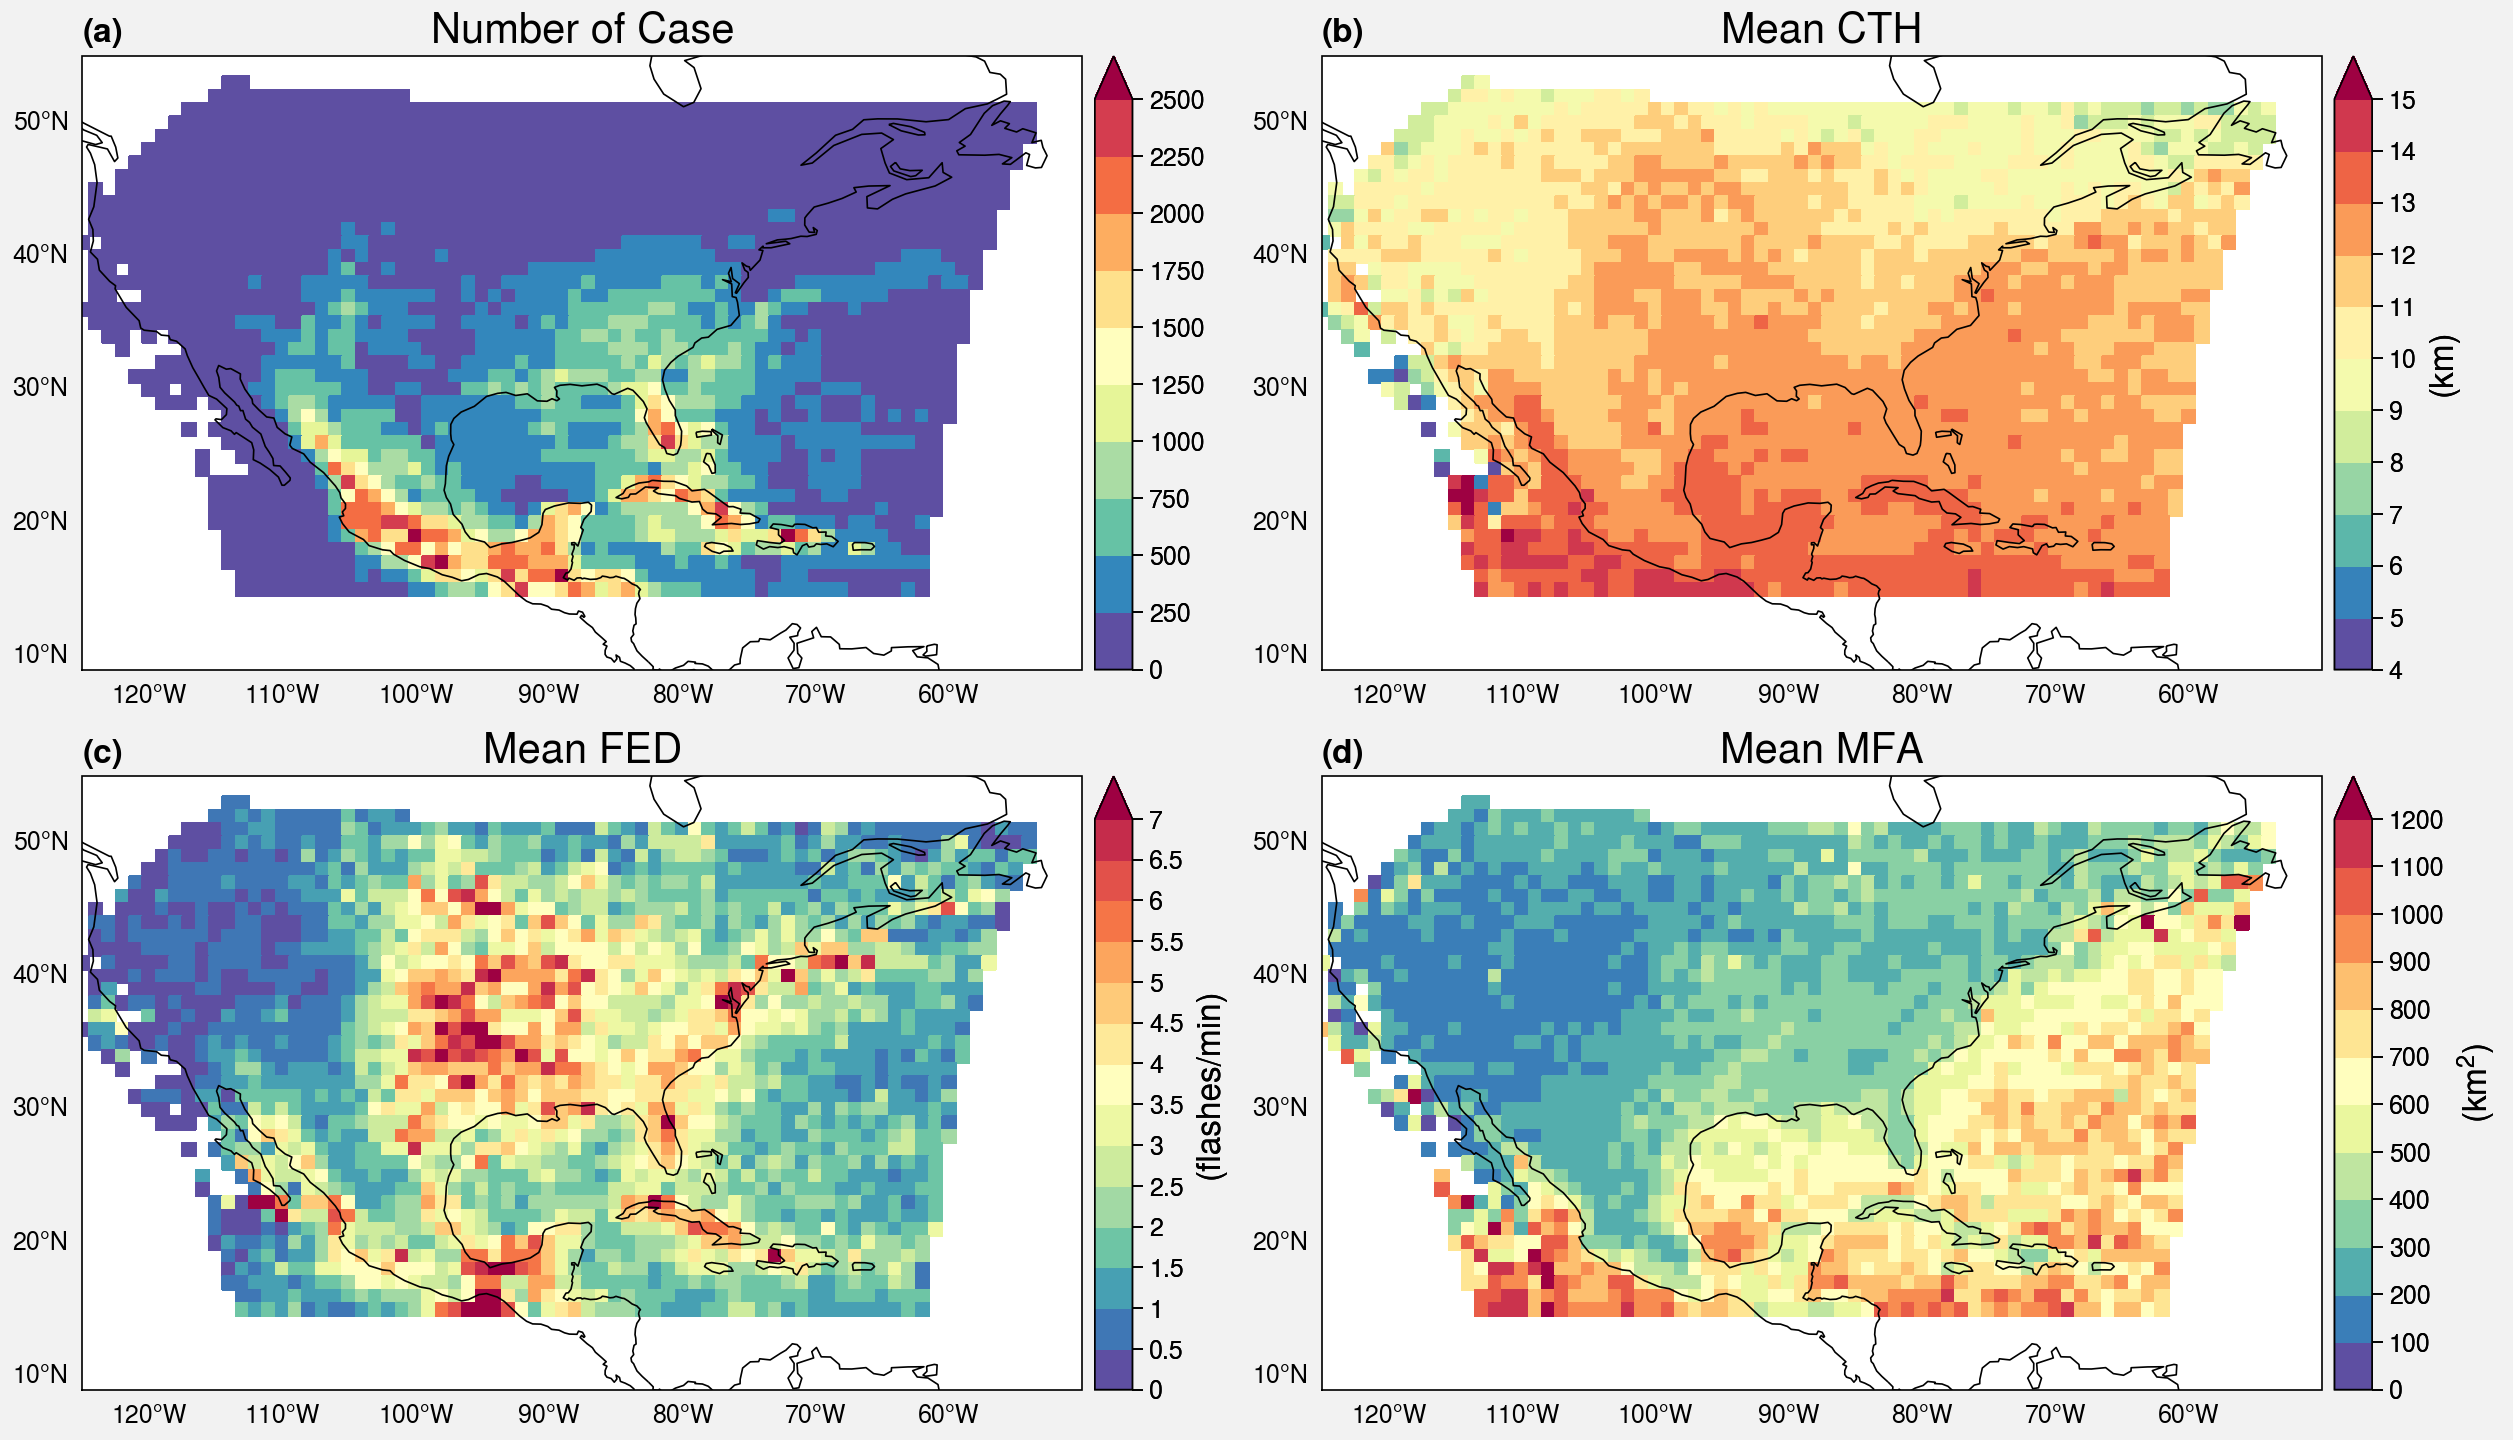

In [29]:
fig, axs = plot.subplots(proj='pcarree', ncols=2, nrows=2, axwidth=5)

plot_casenum(axs[0], lon_coord, lat_coord, counts.where(counts>0),
             'Number of Case', '', vmax=2500, ticks=250)
plot_casenum(axs[1], lon_coord, lat_coord, ht_mean,
             'Mean CTH', '(km)', vmin=4, vmax=15, ticks=1)
plot_casenum(axs[2], lon_coord, lat_coord, fed_mean,
             'Mean FED', '(flashes/min)', vmax=7, ticks=0.5)#vmax=1.35, ticks=0.15)
plot_casenum(axs[3], lon_coord, lat_coord, mfa_mean,
             'Mean MFA', '(km$^2$)', vmax=1200, ticks=100)

axs.format(lonlim=(-125, -50), latlim=(9, 55),
           abc=True, abcloc='l', abcstyle='(a)', abcsize=12,
           coast=True, grid=False,
           latlines=10, lonlines=10,
           lonlabels=True, latlabels=True,
           titlesize=15)

fig.savefig('../figures/distribution.png')

In [16]:
da_count = xr.DataArray(counts, dims=['lat', 'lon'], coords={'lat': lat_coord[:, 0], 'lon': lon_coord[0, :]})
print('Percentage of case in the south of 40N: ', da_count.sel(lat=slice(40, None)).sum()/da_count.sum()*1e2)
print('Percentage of case in the SE: ', da_count.sel(lat=slice(38, 25), lon=slice(-98, -65)).sum()/da_count.sum()*1e2)

Percentage of case in the south of 40N:  <xarray.DataArray ()>
array(91.77718999)
Percentage of case in the SE:  <xarray.DataArray ()>
array(29.252424)


## Outliers

The lightning emitted from the low cloud in the Pacific Ocean near San Diego seems abnormal, but that's true! Let's zoom in:

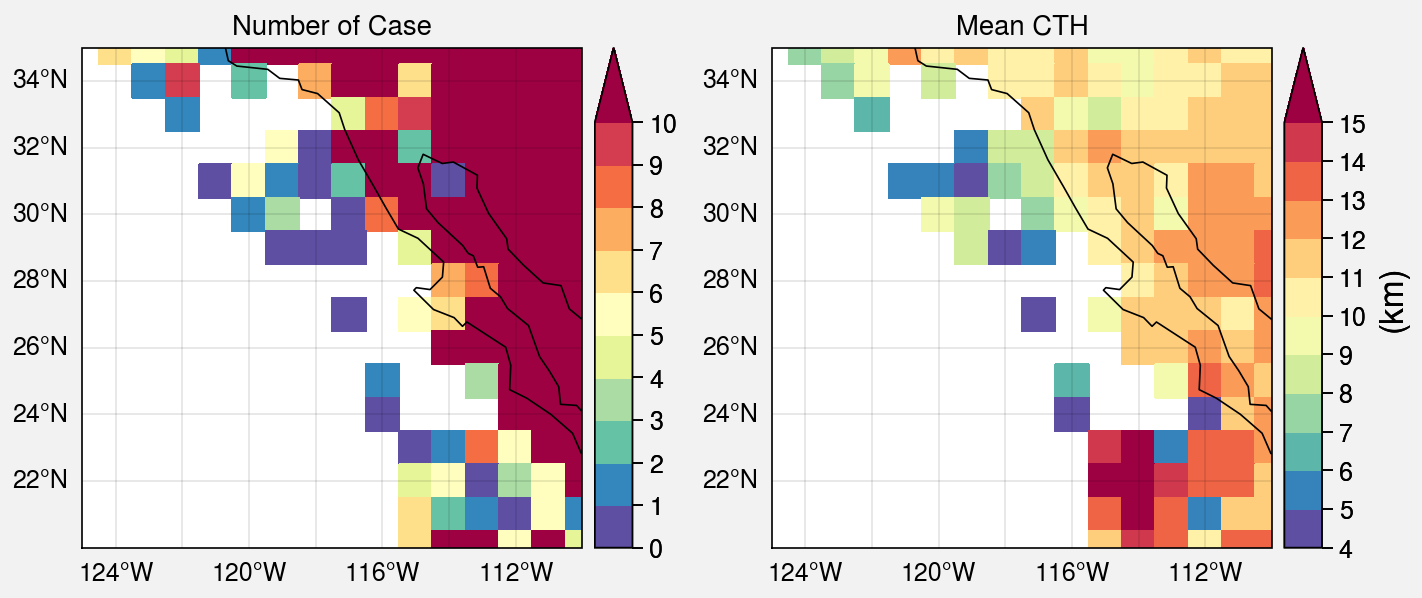

In [17]:
fig, axs = plot.subplots(proj='pcarree', ncols=2)

plot_casenum(axs[0], lon_coord, lat_coord, counts.where(counts>0),
             'Number of Case', '', vmax=10, ticks=1)

plot_casenum(axs[1], lon_coord, lat_coord, ht_mean,
             'Mean CTH', '(km)', vmin=4, vmax=15, ticks=1)


axs.format(lonlim=(-125, -110), latlim=(20, 35),
           coast=True,
           latlines=2, lonlines=2,
           lonlabels=True, latlabels=True)

In [18]:
df[(df['HT']<5) & (df['lon']>-118) & (df['lon']<-116) & (df['lat']>24) & (df['lat']<26)]

,time,x,y,lon,lat,HT,C13,average_flash_area,flash_extent_density,total_energy,minimum_flash_area,w,tbb_track,cth_track,cell,time_cell,lapse_rate,area,region
11783,2020-08-20T12:16:18,-3.602221e+06,2.479971e+06,-116.19281,24.444779,4.366549,247.220001,1050.0,0.4375,13.73373,1050.0,6.623331,248.750395,4.219136,1447625,20,-0.006035,ocean,Other


I created another notebook to check the special case: https://gist.github.com/zxdawn/37fba28ce44a7c4a42e468fb8702fd51.

That's actually looks fine!

In [19]:
# df[df['HT']<5].to_xarray().plot.scatter(x='lon', y='lat', hue='HT', cmap='viridis')

In [20]:
# df[df['HT']>10].to_xarray().plot.scatter(x='lon', y='lat', hue='HT', cmap='viridis')